<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_Simulates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize
import time


In [79]:
def normal_data_generator(m, n, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd, sigma, na_portion, rank, random_seed):
  """
  Generator function for normal simulated data:
  m: The Number of Rows of Feature Matrix(i.e. number of users)
  n: The Number of Columns of Feature Matrix(i.e. number of items)
  r_mu: The mean of true_r
  r_sd: The standard deviation of true_r
  c_mu: The mean of true_c
  c_sd: The standard deviation of true_c
  u_mu: The mean of true_u
  u_sd: The standard deviation of true_u
  v_mu: The mean of true_v
  v_sd: The standard deviation of true_v
  sigma: The noise standard deviation
  na_proportion: Proportion of missing data
  rank: (k), The rank for model
  random_seed: self-explained
  """
  np.random.seed(random_seed)
  k = rank

  true_r = norm.rvs(loc=r_mu, size=m, scale=r_sd)
  true_c = norm.rvs(loc=c_mu, size=m, scale=c_sd)

  true_u = norm.rvs(loc=u_mu, size=(m, k), scale=u_sd)
  true_v = norm.rvs(loc=v_mu, size=(n, k), scale=v_sd)

  sigma = sigma

  mu_X = true_r[:, np.newaxis] + true_c + np.dot(true_u, true_v.T)

  error = sigma * norm.rvs(size=(m, n))
  X = mu_X + error

  prob_miss = na_portion
  missing = np.random.choice([True, False], size=(m, n), p=[prob_miss, 1 - prob_miss])
  X[missing] = np.nan
  return X, true_r, true_c, true_u, true_v


Configuration 1:

* Matrix Size: 200 * 200
* True R Mean: 40
* True R SD: 1
* True C Mean: 40
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 0.1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100



In [80]:
#-----------------
# Configuration 1:

# Matrix Size: 200 * 200
# True R Mean: 40
# True R SD: 1
# True C Mean: 40
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 0.1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Seed: 100
#-----------------

X_config1, true_r_config1, true_c_config1, true_u_congfig1, true_v_config1 = normal_data_generator(m=200, n=200, r_mu=40, r_sd=1, c_mu=40, c_sd=1, u_mu=0,u_sd=0.1,v_mu=0,v_sd=1,sigma=0.3,na_portion=0.3,rank=2,random_seed=100)
#plt.hist(np.dot(true_u, true_v.T).flat)
#plt.hist((true_r[:, np.newaxis] + true_c ).flat)

Configuration 2:
* Matrix Size: 200 * 200
* True R Mean: 30
* True R SD: 1
* True C Mean: 30
* True C SD: 1
* True U Mean: 5
* True V Mean: 4
* True U/V STD: 5
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 4
* Seed: 200

In [81]:
#-----------------
# Configuration 2:

# Matrix Size: 200 * 200
# True R Mean: 30
# True R SD: 1
# True C Mean: 30
# True C SD: 1
# True U Mean: 5
# True V Mean: 4
# True U/V STD: 5
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 4
# Seed: 200
#-----------------
X_config2, true_r_config2, true_c_config2, true_u_congfig2, true_v_config2 = normal_data_generator(m=200, n=200, r_mu=30, r_sd=1, c_mu=30, c_sd=1, u_mu=5,u_sd=5,v_mu=4,v_sd=5,sigma=0.3,na_portion=0.3,rank=4,random_seed=200)

Configuration 3:
* Matrix Size: 200 * 200
* True R Mean: 5
* True R SD: 1.5
* True C Mean: -4
* True C SD: 1.5
* True U Mean: 12
* True U SD: 6
* True V Mean: 7
* True V STD: 3
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 3
* Seed: 489

In [82]:
#-----------------
# Configuration 3:

# Matrix Size: 200 * 200
# True R Mean: 5
# True R SD: 1.5
# True C Mean: -4
# True C SD: 1.5
# True U Mean: 12
# True U SD: 6
# True V Mean: 7
# True V STD: 3
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 3
# Seed: 489
#-----------------
X_config3, true_r_config3, true_c_config3, true_u_congfig3, true_v_config3 = normal_data_generator(m=200, n=200, r_mu=5, r_sd=1.5, c_mu=-4, c_sd=1.5, u_mu=12,u_sd=6,v_mu=7,v_sd=3,sigma=0.3,na_portion=0.3,rank=3,random_seed=489)

In [83]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [84]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad

# BFGS METHOD, set method to "L-BFGS-B" for LBFGS
# Init all parameters one time
def optimize_with_bfgs_all_init(X, k, tau, loss_array, mu, sd, method="BFGS"):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(mu, sd, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V

# Initi parameters separately
def optimize_with_bfgs_sep_init(X, k, tau, loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd, method="BFGS"):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = np.random.normal(r_mu, r_sd, m)
    initial_c_param = np.random.normal(c_mu, c_sd, n)
    initial_u_param = np.random.normal(u_mu, u_sd, m*k)
    initial_v_param = np.random.normal(v_mu, v_sd, n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_u_param, initial_v_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='BFGS', jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V


In [85]:
def runner_all_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, mu, sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_all_init(config_matrix, rank, tau, loss_array, mu, sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"SETUP {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"SETUP {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_all_init(config_matrix, rank, tau, lbfgs_loss_array, mu, sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"SETUP {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"SETUP {setup_num} LBFGS Iterations: ", lbfgs_iter_num)

  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

def runner_sep_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"SETUP {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"SETUP {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, lbfgs_loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"SETUP {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"SETUP {setup_num} LBFGS Iterations: ", lbfgs_iter_num)

  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

def plotter(setup_num, loss_array, lbfgs_loss_array):
  bfgs_horizontal = np.arange(1, len(loss_array) + 1)
  lbfgs_horizontal = np.arange(1, len(lbfgs_loss_array) + 1)
  bfgs_log = np.log(loss_array)
  lbfgs_log = np.log(np.array(lbfgs_loss_array))
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].set_ylabel("LOSS")
  axs[0].set_xlabel("Number of Iterations")
  axs[0].set_title(f"SETUP {setup_num}'s LOSS v.s. Iterations")
  axs[0].plot(bfgs_horizontal, loss_array, label="BFGS", color='r')
  axs[0].plot(lbfgs_horizontal, lbfgs_loss_array, label="LBFGS", color='b')
  axs[0].legend()


  axs[1].set_ylabel("LOG LOSS")
  axs[1].set_xlabel("Number of Iterations")
  axs[1].set_title(f"SETUP {setup_num}'s LOG LOSS v.s. Iterations")
  axs[1].plot(bfgs_horizontal, bfgs_log, label="BFGS", color='r')
  axs[1].plot(lbfgs_horizontal, lbfgs_log, label="LBFGS", color='b')
  axs[1].legend()

# SETUP 1  
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 40
* True R SD: 1
* True C Mean: 40
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 0.1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100

Initialization:
* All INIT
* Mu: 0
* SD: 0.3

Expectile:
* Tau: 0.6

In [86]:
# SETUP 1:
#----------
# Configuration: 1
# Initialization: ALL, Mu: 0, SD: 0.3
# Tau: 0.6
#----------
rank_1 = 2
tau_1 = 0.6
mu_1 = 0
sd_1 = 0.3

loss_array_1 = []
lbfgs_loss_array_1 = []
R_1, C_1, U_1, V_1, l_R_1, l_C_1, l_U_1, l_V_1 = runner_all_init(1, X_config1, rank_1, tau_1, loss_array_1, lbfgs_loss_array_1, mu_1, sd_1)

BFGS Final Loss: 0.04171537491666105
SETUP 1 BFGS Takes about:  40.42888689041138  (s)
SETUP 1 BFGS Iterations:  233
------------------------------------
L-BFGS-B Final Loss: 0.04180409291060678
SETUP 1 LBFGS Takes about:  0.531029224395752  (s)
SETUP 1 LBFGS Iterations:  537


Loss Plot For SETUP 1:

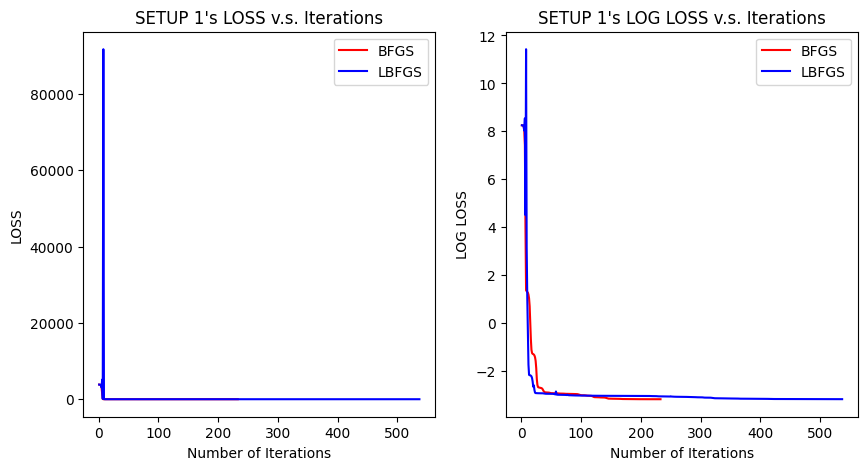

In [87]:
# SETUP 1 Plot
plotter(1, loss_array_1, lbfgs_loss_array_1)

# SETUP 2
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 40
* True R SD: 1
* True C Mean: 40
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 0.1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100

Initialization:
* All INIT
* Mu: 60
* SD: 10

Expectile:
* Tau: 0.6



In [88]:
# SETUP 2:
#----------
# Configuration: 1
# Initialization: ALL, Mu: 60, SD: 10
# Tau: 0.6
#----------
rank_2 = 2
tau_2 = 0.6
mu_2 = 60
sd_2 = 10

loss_array_2 = []
lbfgs_loss_array_2 = []
R_2, C_2, U_2, V_2, l_R_2, l_C_2, l_U_2, l_V_2 = runner_all_init(2, X_config1, rank_2, tau_2, loss_array_2, lbfgs_loss_array_2, mu_2, sd_2)

BFGS Final Loss: 0.05256295103530131
SETUP 2 BFGS Takes about:  61.065537214279175  (s)
SETUP 2 BFGS Iterations:  518
------------------------------------
L-BFGS-B Final Loss: 0.05254160769538353
SETUP 2 LBFGS Takes about:  0.25957703590393066  (s)
SETUP 2 LBFGS Iterations:  245


Loss Plot For SETUP 2:

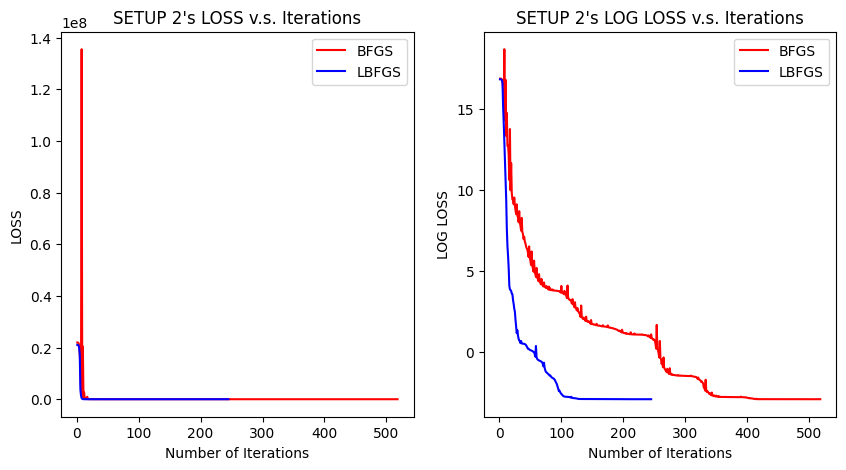

In [89]:
# SETUP 2 Plot
plotter(2, loss_array_2, lbfgs_loss_array_2)

# SETUP 3
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 30
* True R SD: 1
* True C Mean: 30
* True C SD: 1
* True U Mean: 5
* True V Mean: 4
* True U/V STD: 5
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 4
* Seed: 200

Initialization:
* All INIT
* Mu: 25
* SD: 10

Expectile:
* Tau: 0.6


In [90]:
# SETUP 3:
#----------
# Configuration: 2
# Initialization: ALL, Mu: 25, SD: 10
# Tau: 0.6
#----------
rank_3 = 4
tau_3 = 0.6
mu_3 = 25
sd_3 = 10

loss_array_3 = []
lbfgs_loss_array_3 = []
R_3, C_3, U_3, V_3, l_R_3, l_C_3, l_U_3, l_V_3 = runner_all_init(3, X_config2, rank_3, tau_3, loss_array_3, lbfgs_loss_array_3, mu_3, sd_3)

BFGS Final Loss: 0.042643907028410234
SETUP 3 BFGS Takes about:  381.79816794395447  (s)
SETUP 3 BFGS Iterations:  583
------------------------------------
L-BFGS-B Final Loss: 0.04046923642714026
SETUP 3 LBFGS Takes about:  0.3068370819091797  (s)
SETUP 3 LBFGS Iterations:  281


Loss Plot For Setup 3

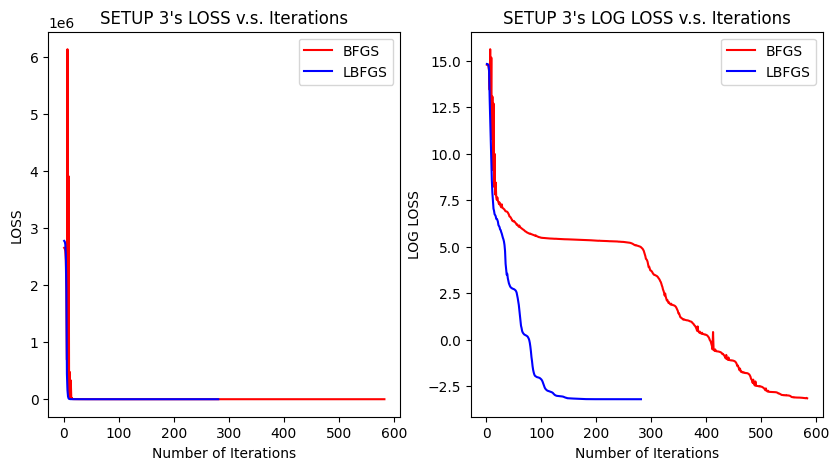

In [91]:
# SETUP 3 Plot
plotter(3, loss_array_3, lbfgs_loss_array_3)

# SETUP 4
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 30
* True R SD: 1
* True C Mean: 30
* True C SD: 1
* True U Mean: 5
* True V Mean: 4
* True U/V STD: 5
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 4
* Seed: 200

Initialization:
* Sep INIT
* R_Mu: 15
* R_SD: 3
* C_Mu: 10
* C_SD: 2
* U_Mu: 15
* U_SD: 4.5
* V_Mu: 2.5
* V_SD: 1

Expectile:
* Tau: 0.6


In [92]:
# SETUP 4:
#----------
# Configuration: 2
# Initialization: SEP, R_Mu: 15, R_SD: 3, C_Mu:10, U_Mu: 15, U_SD: 4.5, V_Mu: 2.5, V_SD: 1
# Tau: 0.6
#----------
rank_4 = 4
tau_4 = 0.6
r_mu_4 = 15
r_sd_4 = 3
c_mu_4 = 10
c_sd_4 = 2
u_mu_4 = 15
u_sd_4 = 4.5
v_mu_4 = 2.5
v_sd_4 = 1

loss_array_4 = []
lbfgs_loss_array_4 = []
R_4, C_4, U_4, V_4, l_R_4, l_C_4, l_U_4, l_V_4 = runner_sep_init(4, X_config2, rank_4, tau_4, loss_array_4, lbfgs_loss_array_4, r_mu_4, r_sd_4, c_mu_4, c_sd_4, u_mu_4, u_sd_4, v_mu_4, v_sd_4)

BFGS Final Loss: 0.04046926190109831
SETUP 4 BFGS Takes about:  203.84844398498535  (s)
SETUP 4 BFGS Iterations:  294
------------------------------------
L-BFGS-B Final Loss: 0.040469290454129656
SETUP 4 LBFGS Takes about:  211.1813361644745  (s)
SETUP 4 LBFGS Iterations:  299


Loss Plot for SETUP 4

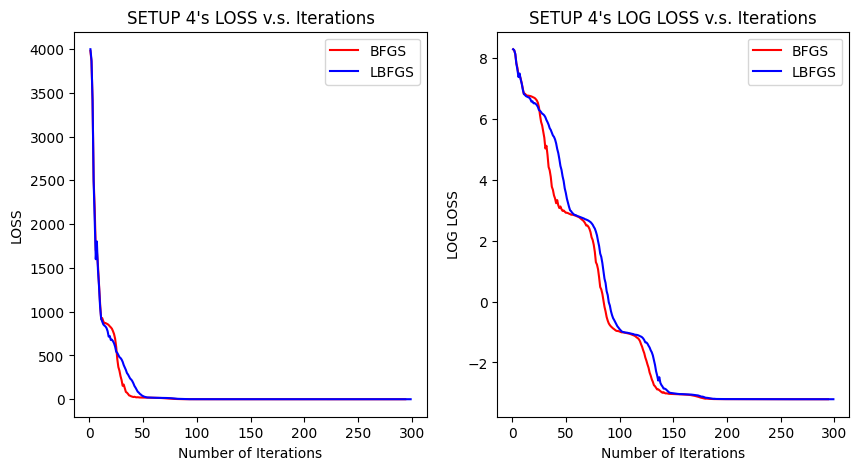

In [93]:
# SETUP PLOT 4
plotter(4, loss_array_4, lbfgs_loss_array_4)

# SETUP 5
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 5
* True R SD: 1.5
* True C Mean: -4
* True C SD: 1.5
* True U Mean: 12
* True U SD: 6
* True V Mean: 7
* True V STD: 3
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 3
* Seed: 489

Initialization:
* Sep INIT
* R_Mu: 15
* R_SD: 3
* C_Mu: 10
* C_SD: 2
* U_Mu: 15
* U_SD: 4.5
* V_Mu: 2.5
* V_SD: 1

Expectile:
* Tau: 0.6


In [94]:
# SETUP 5:
#----------
# Configuration: 3
# Initialization: SEP, R_Mu: 15, R_SD: 3, C_Mu:10, U_Mu: 15, U_SD: 4.5, V_Mu: 2.5, V_SD: 1
# Tau: 0.6
#----------
rank_5 = 4
tau_5 = 0.6
r_mu_5 = 15
r_sd_5 = 3
c_mu_5 = 10
c_sd_5 = 2
u_mu_5 = 15
u_sd_5 = 4.5
v_mu_5 = 2.5
v_sd_5 = 1

loss_array_5 = []
lbfgs_loss_array_5 = []
R_5, C_5, U_5, V_5, l_R_5, l_C_5, l_U_5, l_V_5 = runner_sep_init(5, X_config3, rank_5, tau_5, loss_array_5, lbfgs_loss_array_5, r_mu_5, r_sd_5, c_mu_5, c_sd_5, u_mu_5, u_sd_5, v_mu_5, v_sd_5)

BFGS Final Loss: 0.040449724451707046
SETUP 5 BFGS Takes about:  247.0853123664856  (s)
SETUP 5 BFGS Iterations:  352
------------------------------------
L-BFGS-B Final Loss: 0.04038060156906137
SETUP 5 LBFGS Takes about:  248.8561372756958  (s)
SETUP 5 LBFGS Iterations:  356


Loss Plot for SETUP 5

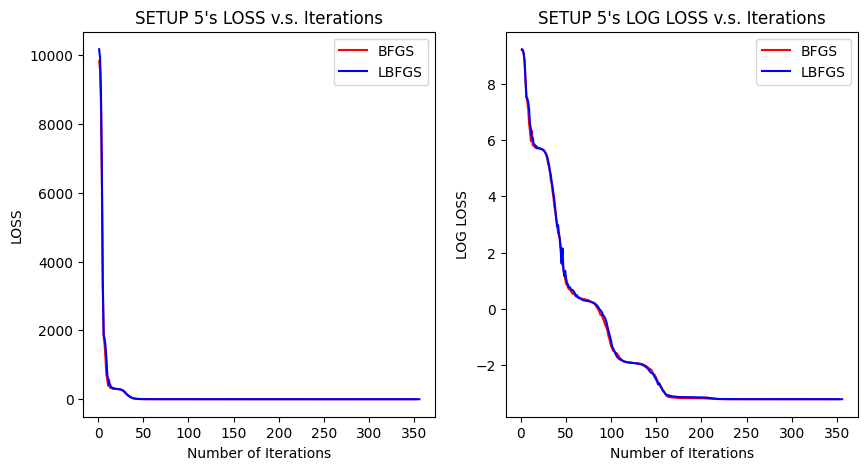

In [95]:
# SETUP PLOT 5
plotter(5, loss_array_5, lbfgs_loss_array_5)

In [96]:
# X_hat = R[:, np.newaxis] + C + U @ V.T
# X_hat

# X_hat_l = R_l[:, np.newaxis] + C_l, + U_l @ V_l.T
# X_hat_l

In [97]:
# print("BFGS Feature Difference: ", X_hat - mu_X)
# #type(X_hat)
# #X_hat.shape
# residual = (X_hat - mu_X).ravel().std()
# print("BFGS Residual: ", residual)
# #type(residual)
# # plt.hist(residual)
# print("LBFGS Featrue Difference: ", X_hat_l - mu_X)
# residual_l = (X_hat_l - mu_X).ravel().std()
# print("LBFGS Residual: ", residual_l)

In [98]:
# print("BFGS R's diff: ",true_r - R)
# print("LBFGS R's diff: ", true_r - R_l)

In [99]:
# print("BFGS C's difference: ", true_c - C)
# print("LBFGS C's difference: ", true_c - C_l)

In [100]:
# print("BFGS difference in outer: ", np.outer(U, V) - np.outer(true_u, true_v))
# print("LBFGS difference in outer: ", np.outer(U_l, V_l) - np.outer(true_u, true_v))